In [304]:
import itertools
import functools
import os
import math

import pmdarima as pm
from pmdarima import model_selection

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Century Schoolbook']
rcParams['font.size'] = 14
rcParams['figure.dpi'] = 300
rcParams['text.usetex'] = False
from matplotlib.markers import CARETDOWNBASE, CARETUPBASE
import matplotlib.dates as mdates

import datetime as dt
from datetime import date, datetime, timedelta

import locale
locale.setlocale(locale.LC_ALL, 'it_IT')

from ETL_utilities import it_data_load, fix_2020_03_10, add_delta_growth_perc, add_ra, add_ra_days
from formatting_utilities import format_dates, format_dates_from_numbers, LegendTitle
from file_utilities import save_in_dir
from common_data import REGIONS_POP

%load_ext autoreload
%autoreload 2

# Global constants
# PLEASE CUSTOMIZE
OUTPUT_PATH = '../output'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [327]:
# Caricamento dei dati dalla Protezione Civile
ds_it = it_data_load()

# Sanity check
ds_it.tail(10)

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati,note_it,note_en
data,,,,,,,,,,,,,,,
2020-05-01,ITA,17569,1578,19147,81796,100943,-608,1965,78249,28236,207428,2053425,1398633.0,dc-IT-0015,dc-EN-0015
2020-05-02,ITA,17357,1539,18896,81808,100704,-239,1900,79914,28710,209328,2108837,1429864.0,dc-IT-0017,dc-EN-0017
2020-05-03,ITA,17242,1501,18743,81436,100179,-525,1389,81654,28884,210717,2153772,1456911.0,NaN,NaN
2020-05-04,ITA,16823,1479,18302,81678,99980,-199,1221,82879,29079,211938,2191403,1479910.0,dc-IT-0019,dc-EN-0019
2020-05-05,ITA,16270,1427,17697,80770,98467,-1513,1075,85231,29315,213013,2246666,1512121.0,NaN,NaN
2020-05-06,ITA,15769,1333,17102,74426,91528,-6939,1444,93245,29684,214457,2310929,1549892.0,dc-IT-0021,dc-EN-0021
2020-05-07,ITA,15174,1311,16485,73139,89624,-1904,1401,96276,29958,215858,2381288,1563557.0,dc-IT-0023,dc-EN-0023
2020-05-08,ITA,14636,1168,15804,72157,87961,-1663,1327,99023,30201,217185,2445063,1608985.0,dc-IT-0025,dc-EN-0025
2020-05-09,ITA,13834,1034,14868,69974,84842,-3119,1083,103031,30395,218268,2514234,1645076.0,NaN,NaN


In [328]:
# Correzione dati errati 2020-03-10 nazionali
fix_2020_03_10(ds_it)

In [329]:
add_delta_growth_perc(ds_it)
add_ra(ds_it)

In [330]:
# Check
#ds_it.head()
ds_it.loc[:, [
    'totale_casi', 'totale_casi_DELTA', 'totale_casi_DELTA_RA_7', 'tamponi', 'tamponi_DELTA', 'casi_testati_DELTA',
    'tamponi_negativi', 'dimessi_guariti', 'dimessi_guariti_DELTA', 'deceduti', 'deceduti_DELTA', 'positive_test_RATIO',
    'terapia_intensiva_RATIO', 'terapia_intensiva_CUM', 'totale_ospedalizzati_RATIO'
]].tail(10)

,totale_casi,totale_casi_DELTA,totale_casi_DELTA_RA_7,tamponi,tamponi_DELTA,casi_testati_DELTA,tamponi_negativi,dimessi_guariti,dimessi_guariti_DELTA,deceduti,deceduti_DELTA,positive_test_RATIO,terapia_intensiva_RATIO,terapia_intensiva_CUM,totale_ospedalizzati_RATIO
data,,,,,,,,,,,,,,,
2020-05-01,207428,1965.0,1789.142857,2053425,74208.0,43732.0,72243.0,78249,2304.0,28236,269.0,0.026480,0.015633,152719,0.189681
2020-05-02,209328,1900.0,1644.000000,2108837,55412.0,31231.0,53512.0,79914,1665.0,28710,474.0,0.034289,0.015282,154258,0.187639
2020-05-03,210717,1389.0,1552.285714,2153772,44935.0,27047.0,43546.0,81654,1740.0,28884,174.0,0.030911,0.014983,155759,0.187095
2020-05-04,211938,1221.0,1485.000000,2191403,37631.0,22999.0,36410.0,82879,1225.0,29079,195.0,0.032447,0.014793,157238,0.183057
2020-05-05,213013,1075.0,1393.857143,2246666,55263.0,32211.0,54188.0,85231,2352.0,29315,236.0,0.019452,0.014492,158665,0.179725
2020-05-06,214457,1444.0,1277.142857,2310929,64263.0,37771.0,62819.0,93245,8014.0,29684,369.0,0.022470,0.014564,159998,0.186850
2020-05-07,215858,1401.0,1193.285714,2381288,70359.0,13665.0,68958.0,96276,3031.0,29958,274.0,0.019912,0.014628,161309,0.183935
2020-05-08,217185,1327.0,1188.666667,2445063,63775.0,45428.0,62448.0,99023,2747.0,30201,243.0,0.020808,0.013279,162477,0.179671
2020-05-09,218268,1083.0,1211.400000,2514234,69171.0,36091.0,68088.0,103031,4008.0,30395,194.0,0.015657,0.012187,163511,0.175243


In [331]:
SUBTITLE = 'Fonte: Protezione Civile Italia - https://github.com/pcm-dpc/COVID-19 (dati del 10/03/2020 corretti)\nCodice libero: https://github.com/emazep/COVID-19-Statistics'
SUBTITLE_NO_CORR = 'Fonte: Protezione Civile Italia - https://github.com/pcm-dpc/COVID-19\nCodice libero: https://github.com/emazep/COVID-19-Statistics'
SUBTITLE_NO_CORR_ISTAT = 'Fonte: Protezione Civile Italia - https://github.com/pcm-dpc/COVID-19; Istat - http://dati.istat.it/Index.aspx?DataSetCode=DCIS_POPRES1\nCodice libero: https://github.com/emazep/COVID-19-Statistics'

common_plt_params = {'markersize':8, 'linewidth':4}
small_plt_params = {'markersize':6, 'linewidth':3}

DATE_SIZE = 9

GLOBAL_SLACK = 0.54
TAMPONI_MEAN_SLACK = 0.0064

pe_outline = pe.withStroke(linewidth=5, foreground='black')
pe_shadow = pe.SimpleLineShadow(offset=(0,-4), alpha=0.4)
pe_normal = pe.Normal()

In [332]:
MIN_DATE = ds_it.index.min()
MAX_DATE = ds_it.index.max()

def set_xlim(ax, x_axis, slack=0, min_date=MIN_DATE):
    ax.set_xlim(left=min_date, right=x_axis[-1])
    ax.set_xlim(ax.get_xlim()[0]-slack, ax.get_xlim()[1]+slack)

def set_xlim_num(ax, slack=0, min_x=0, max_x=200):
    ax.set_xlim(left=min_x, right=max_x)
    ax.set_xlim(ax.get_xlim()[0]-slack, ax.get_xlim()[1]+slack)

In [364]:
ds = ds_it

def make_arima_pred(ds, column, periods=10, m=1):
    start_day = ds.index.max() + dt.timedelta(days=1)
    x_pred = pd.date_range(start=start_day, periods=periods)

    arima = pm.auto_arima(ds[column], suppress_warnings=True, m=m, stepwise=False, n_jobs=4, max_order=9, maxiter=200)
    predictions, conf_int = arima.predict(n_periods=periods, return_conf_int=True)
    return x_pred, predictions, conf_int, arima

In [334]:
SUBTITLE = 'Fonte: Protezione Civile Italia - https://github.com/pcm-dpc/COVID-19 (dati del 10/03/2020 corretti)\nCodice libero: https://github.com/emazep/COVID-19-Statistics'
SUBTITLE_NO_CORR = 'Fonte: Protezione Civile Italia - https://github.com/pcm-dpc/COVID-19\nCodice libero: https://github.com/emazep/COVID-19-Statistics'
SUBTITLE_NO_CORR_ISTAT = 'Fonte: Protezione Civile Italia - https://github.com/pcm-dpc/COVID-19; Istat - http://dati.istat.it/Index.aspx?DataSetCode=DCIS_POPRES1\nCodice libero: https://github.com/emazep/COVID-19-Statistics'

common_plt_params = {'markersize':8, 'linewidth':4}
small_plt_params = {'markersize':6, 'linewidth':3}

DATE_SIZE = 9

GLOBAL_SLACK = 0.54
TAMPONI_MEAN_SLACK = 0.0064

pe_outline = pe.withStroke(linewidth=5, foreground='black')
pe_shadow = pe.SimpleLineShadow(offset=(0,-4), alpha=0.4)
pe_normal = pe.Normal()

In [335]:
def plot_predictions(ds, column, x_axis, predictions, conf_int, suptitle, legend_title, y_major=500, y_minor=100, min_date=None):
    SLACK = 0.5
    ALPHA = 0.4

    last_date_str = ds.index.max().strftime('%d/%m/%Y')
    
    ax = ds.plot(y=column, label='Valori osservati', **common_plt_params, marker='o', figsize=(16, 8), zorder=3, color='tab:blue')
    ax.plot(x_axis, predictions, label='Valori predetti', **common_plt_params, marker='o', color='magenta')
    plt.fill_between(x_axis, conf_int[:, 0], conf_int[:, 1], alpha=0.4, color='limegreen', label='Intervallo di confidenza al 95%')

    #set_xlim(ax, SLACK)

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_dates))
    ax.tick_params(axis='x', which='both', labelsize=DATE_SIZE)
    ax.xaxis.grid(True, which='both', alpha=ALPHA)

    ax.yaxis.grid(True, which='both', alpha=ALPHA)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(y_major))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(y_minor))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:n}'))
    ax.tick_params(axis='y', which='both', labelsize=9)

    ax.tick_params(axis='y', which='both', right=True, labelright=True)

    plt.xlabel(None)

    set_xlim(ax, x_axis, SLACK, min_date=min_date if min_date else ds.index.min())
    ax.set_ylim(bottom=0)
    
    ax.legend(title='Previsione mediante SARIMA\n'+legend_title+'\nal '+last_date_str, fontsize=14)

    ax.set_title(SUBTITLE, fontsize=14)
    plt.suptitle('     Previsione '+suptitle+' COVID-19 al '+last_date_str, fontsize=22)

    #plt.show()
    
    return plt.gcf()

In [336]:
# Docs on plotting ARIMA predictions & CI
'''
plt.plot(x_axis, predictions, marker='o', alpha=0.75)  # Forecasts
plt.scatter(ds.index, ds[column], alpha=0.4, marker='o')  # Test data
plt.fill_between(x_axis, conf_int[:, 0], conf_int[:, 1], alpha=0.1, color='b')
plt.show()
'''

"\nplt.plot(x_axis, predictions, marker='o', alpha=0.75)  # Forecasts\nplt.scatter(ds.index, ds[column], alpha=0.4, marker='o')  # Test data\nplt.fill_between(x_axis, conf_int[:, 0], conf_int[:, 1], alpha=0.1, color='b')\nplt.show()\n"

[385.83785081 825.43133542 613.95130948 960.49751461 826.23658428
 628.40018649 649.45375769 270.32789585 562.05664715]


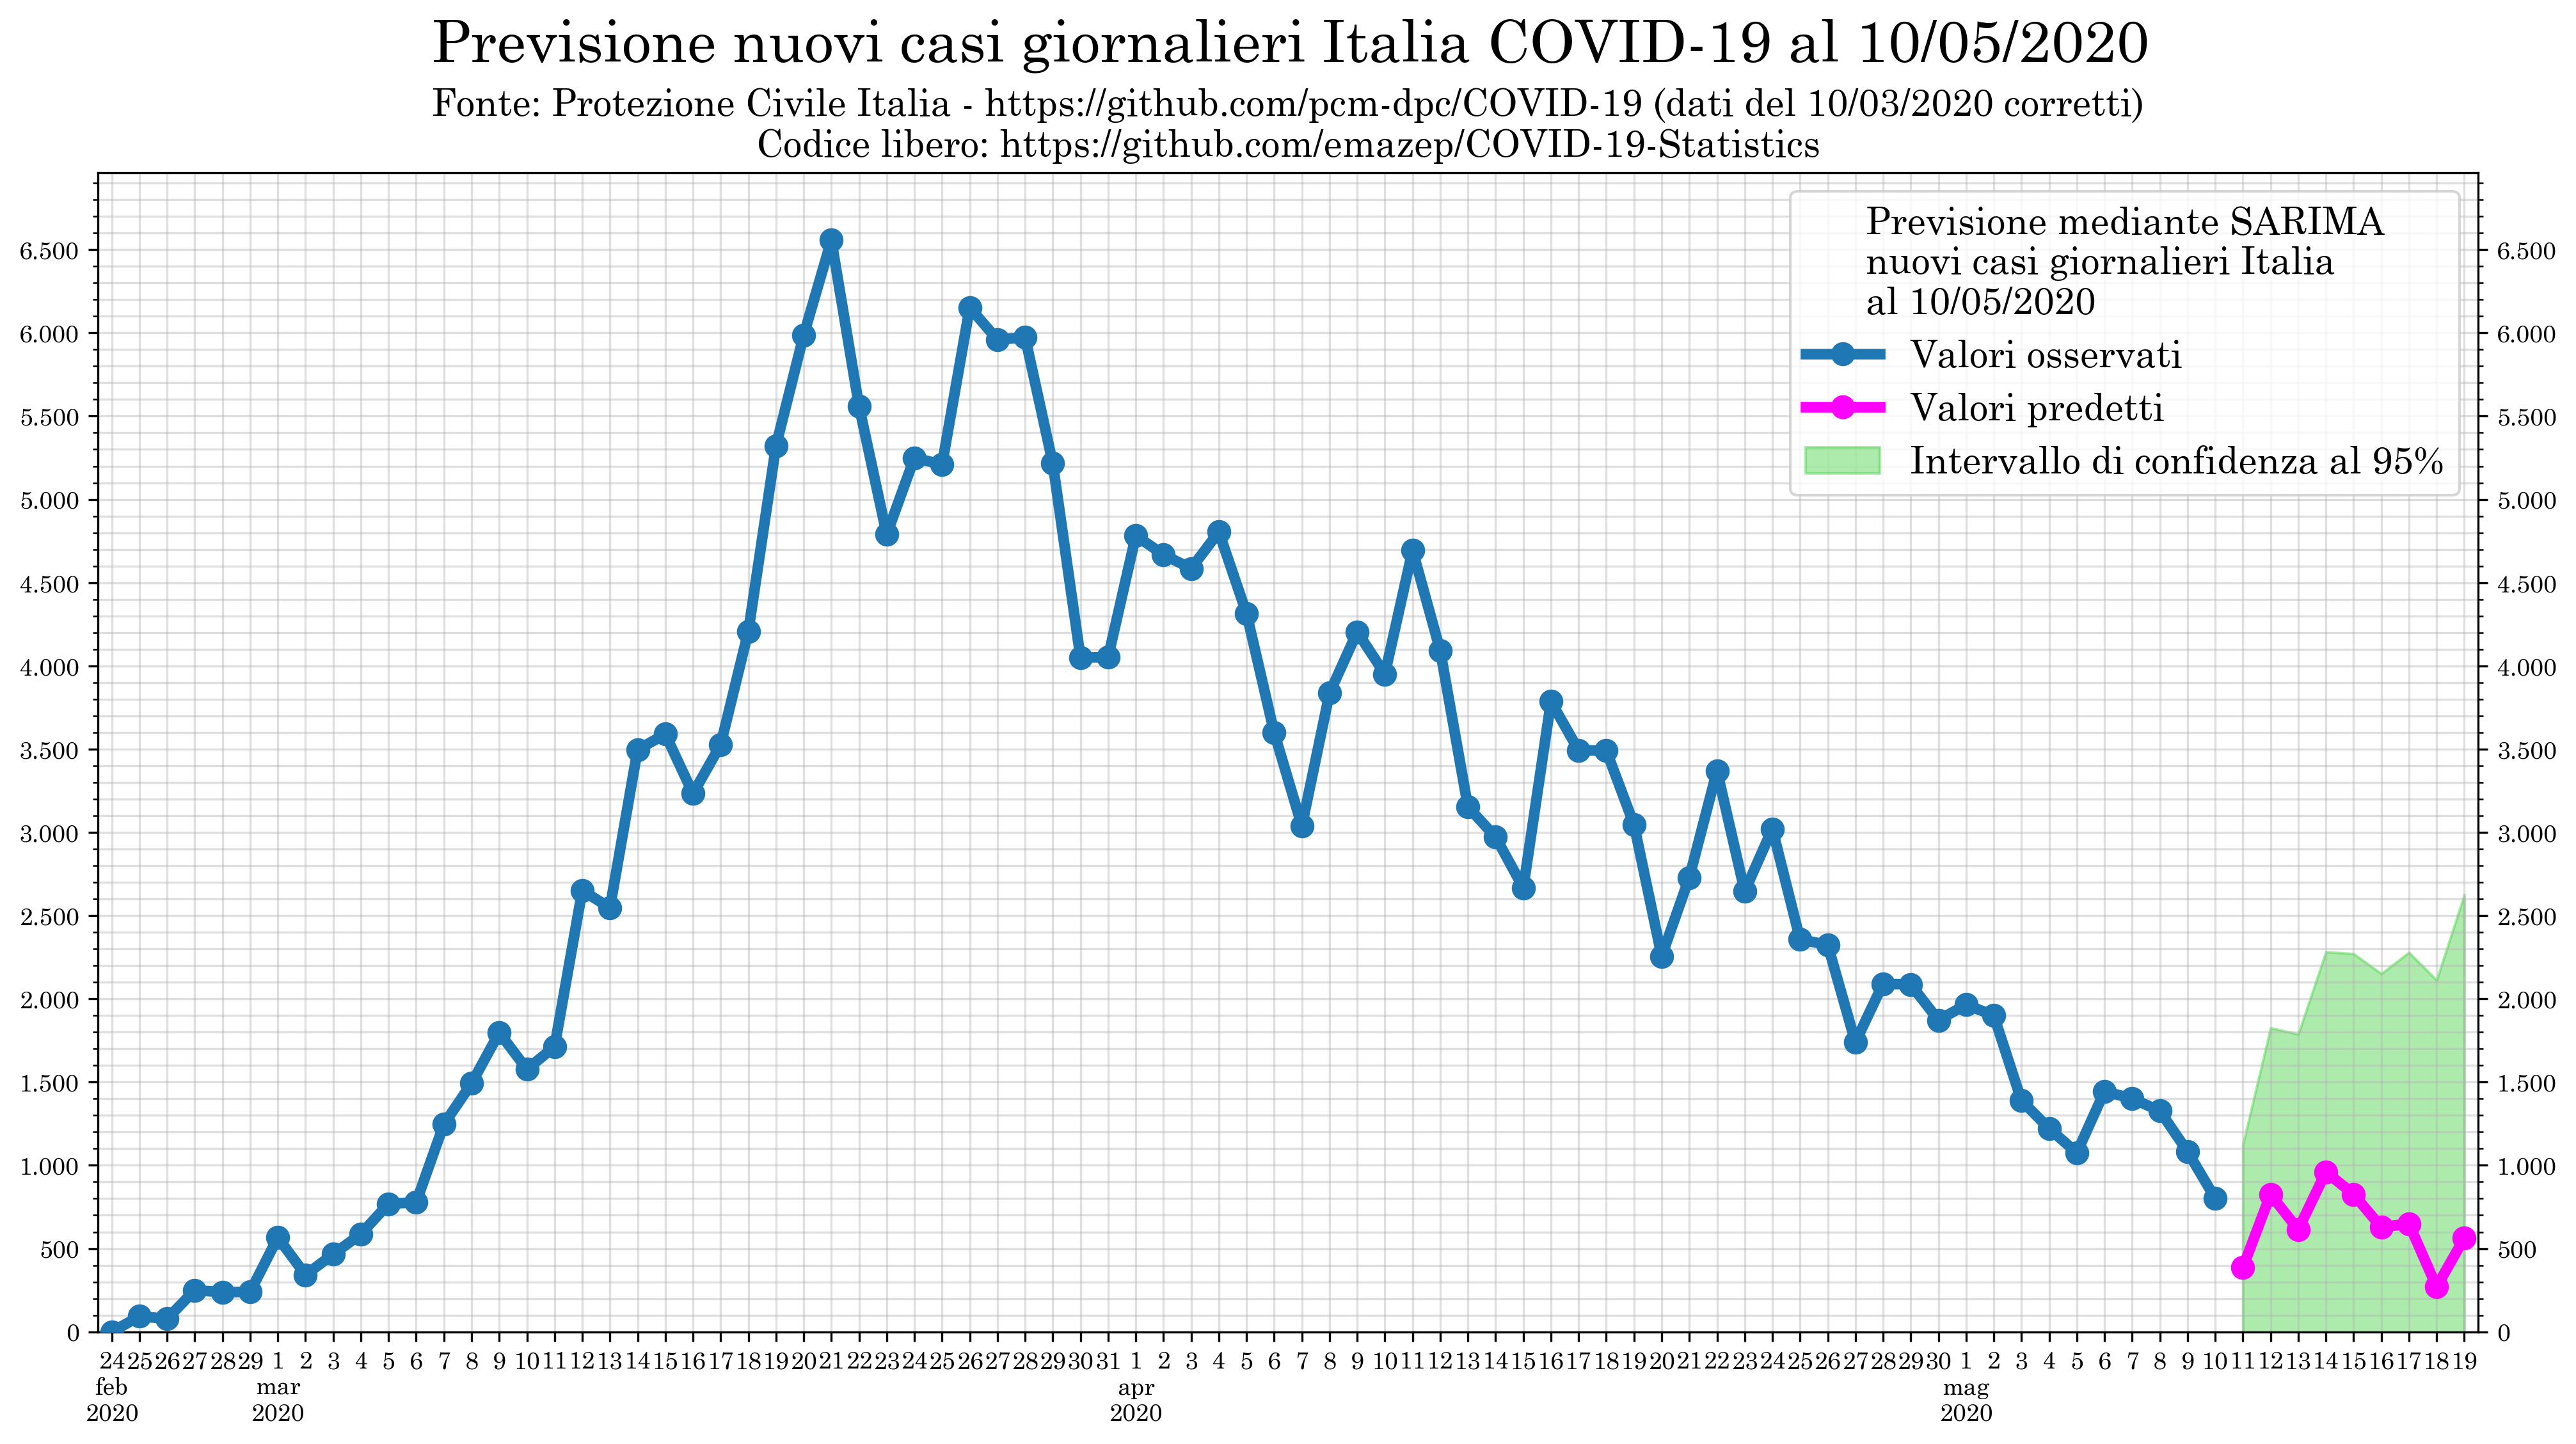

In [362]:
FROM = date.fromisoformat('2020-05-09')
#ds = ds_it[FROM:]
ds = ds_it
column = 'totale_casi_DELTA'
x_pred, predictions, conf_int, arima = make_arima_pred(ds, column, periods=9, m=7)
print(predictions)
fig_ARIMA_totale_casi_DELTA = plot_predictions(
    ds, column, x_pred, predictions, conf_int, 'nuovi casi giornalieri Italia', 'nuovi casi giornalieri Italia', y_major=500, y_minor=100
)

In [363]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   77
Model:             SARIMAX(4, 0, 3)x(2, 0, [], 7)   Log Likelihood                -570.867
Date:                            lun, 11 mag 2020   AIC                           1163.735
Time:                                    01:01:36   BIC                           1189.517
Sample:                                         0   HQIC                          1174.047
                                             - 77                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    205.7149    455.574      0.452      0.652    -687.194    1098.624
ar.L1         -1.5439      0.131    -11.764      0.000      -1.801      -1.287
ar.L2         -0.0816      0.120     -0.677      0.498      -0.318       0.155
ar.L3          1.3742      0.108     12.730      0.000       1.163       1.586
ar.L4          0.8723      0.118      7.421      0.000       0.642       1.103
ma.L1          2.4755      0.244     10.127      0.000       1.996       2.955
ma.L2          2.3609      0.445      5.302      0.000       1.488       3.234
ma.L3          0.8242      0.249      3.313      0.001       0.337       1.312
ar.S.L7        0.6249      0.167      3.746      0.000       0.298       0.952
ar.S.L14       0.0265      0.165      0.161      0.872      -0.296       0.349
sigma2      1.389e+05      0.006   2.34e+07      0.000    1.39e+05    1.39e+05
===================================================================================
Ljung-Box (Q):                       41.28   Jarque-Bera (JB):                 0.27
Prob(Q):                              0.41   Prob(JB):                         0.87
Heteroskedasticity (H):               0.90   Skew:                            -0.08
Prob(H) (two-sided):                  0.78   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.1e+25. Standard errors may be unstable.
"""

[762.10685232 704.1625654  705.7719481  942.60215051 968.20246268
 886.75559053 690.70157962 543.30832111 521.89068341]


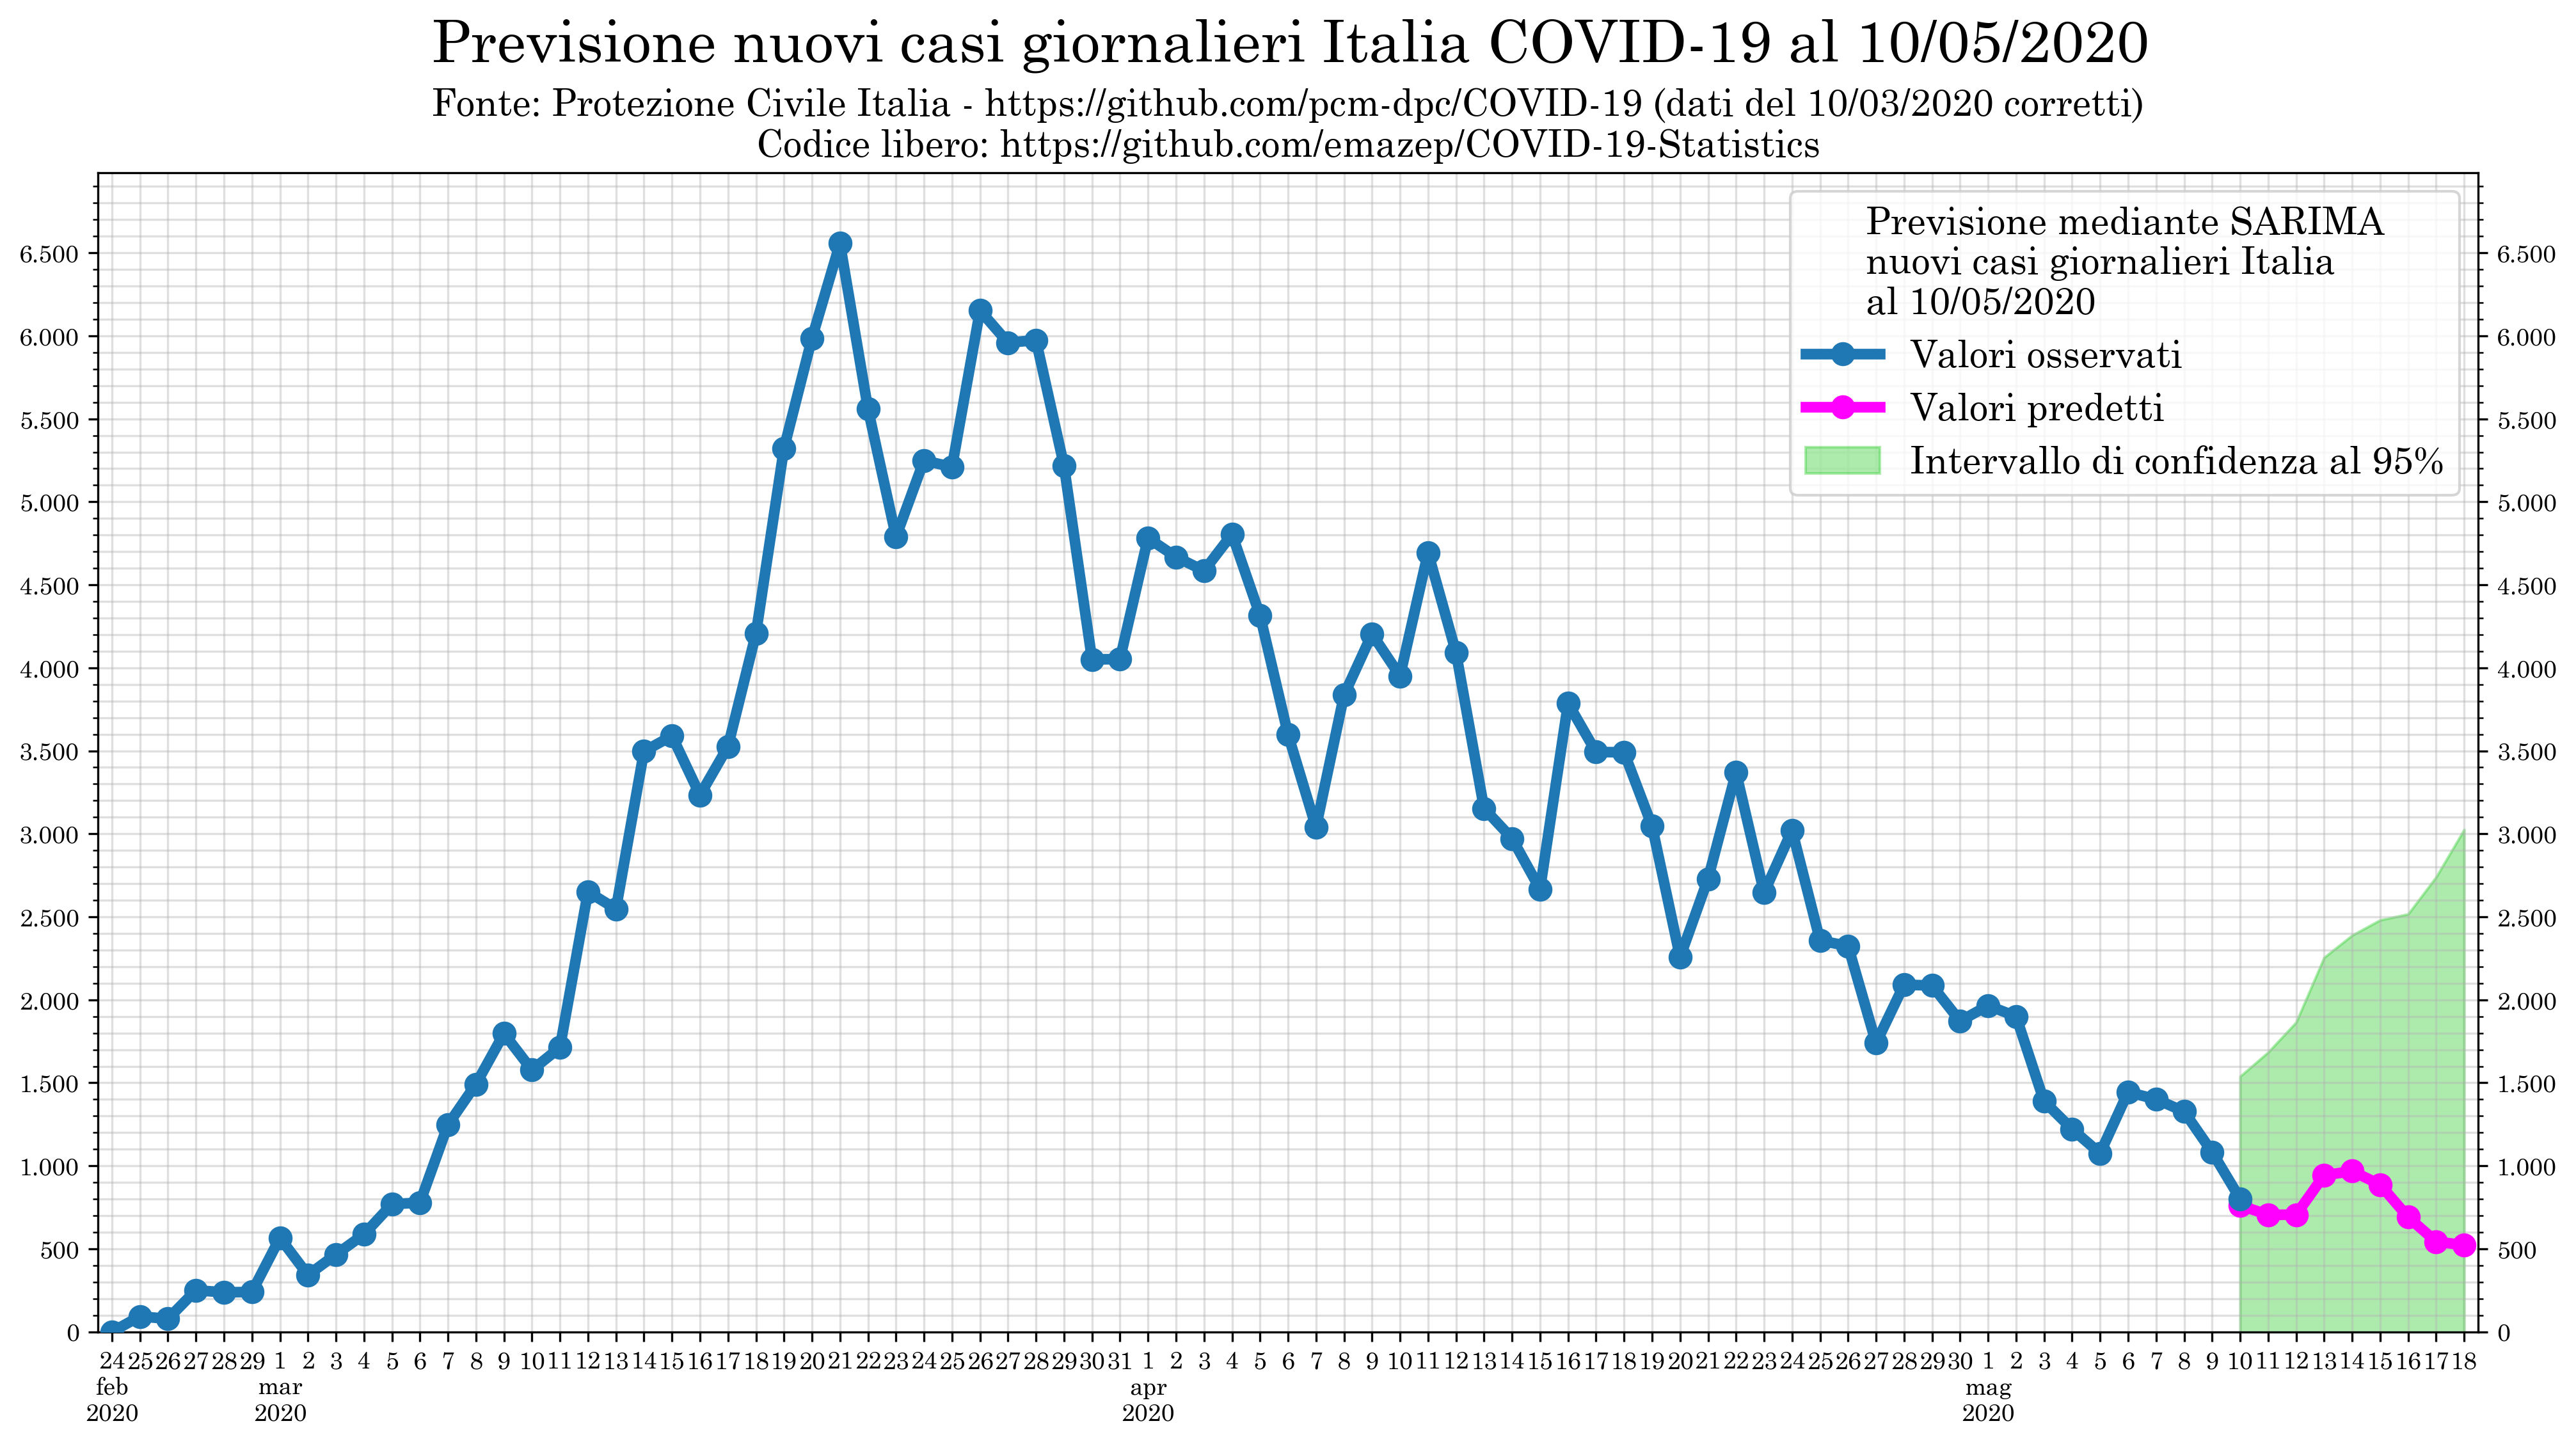

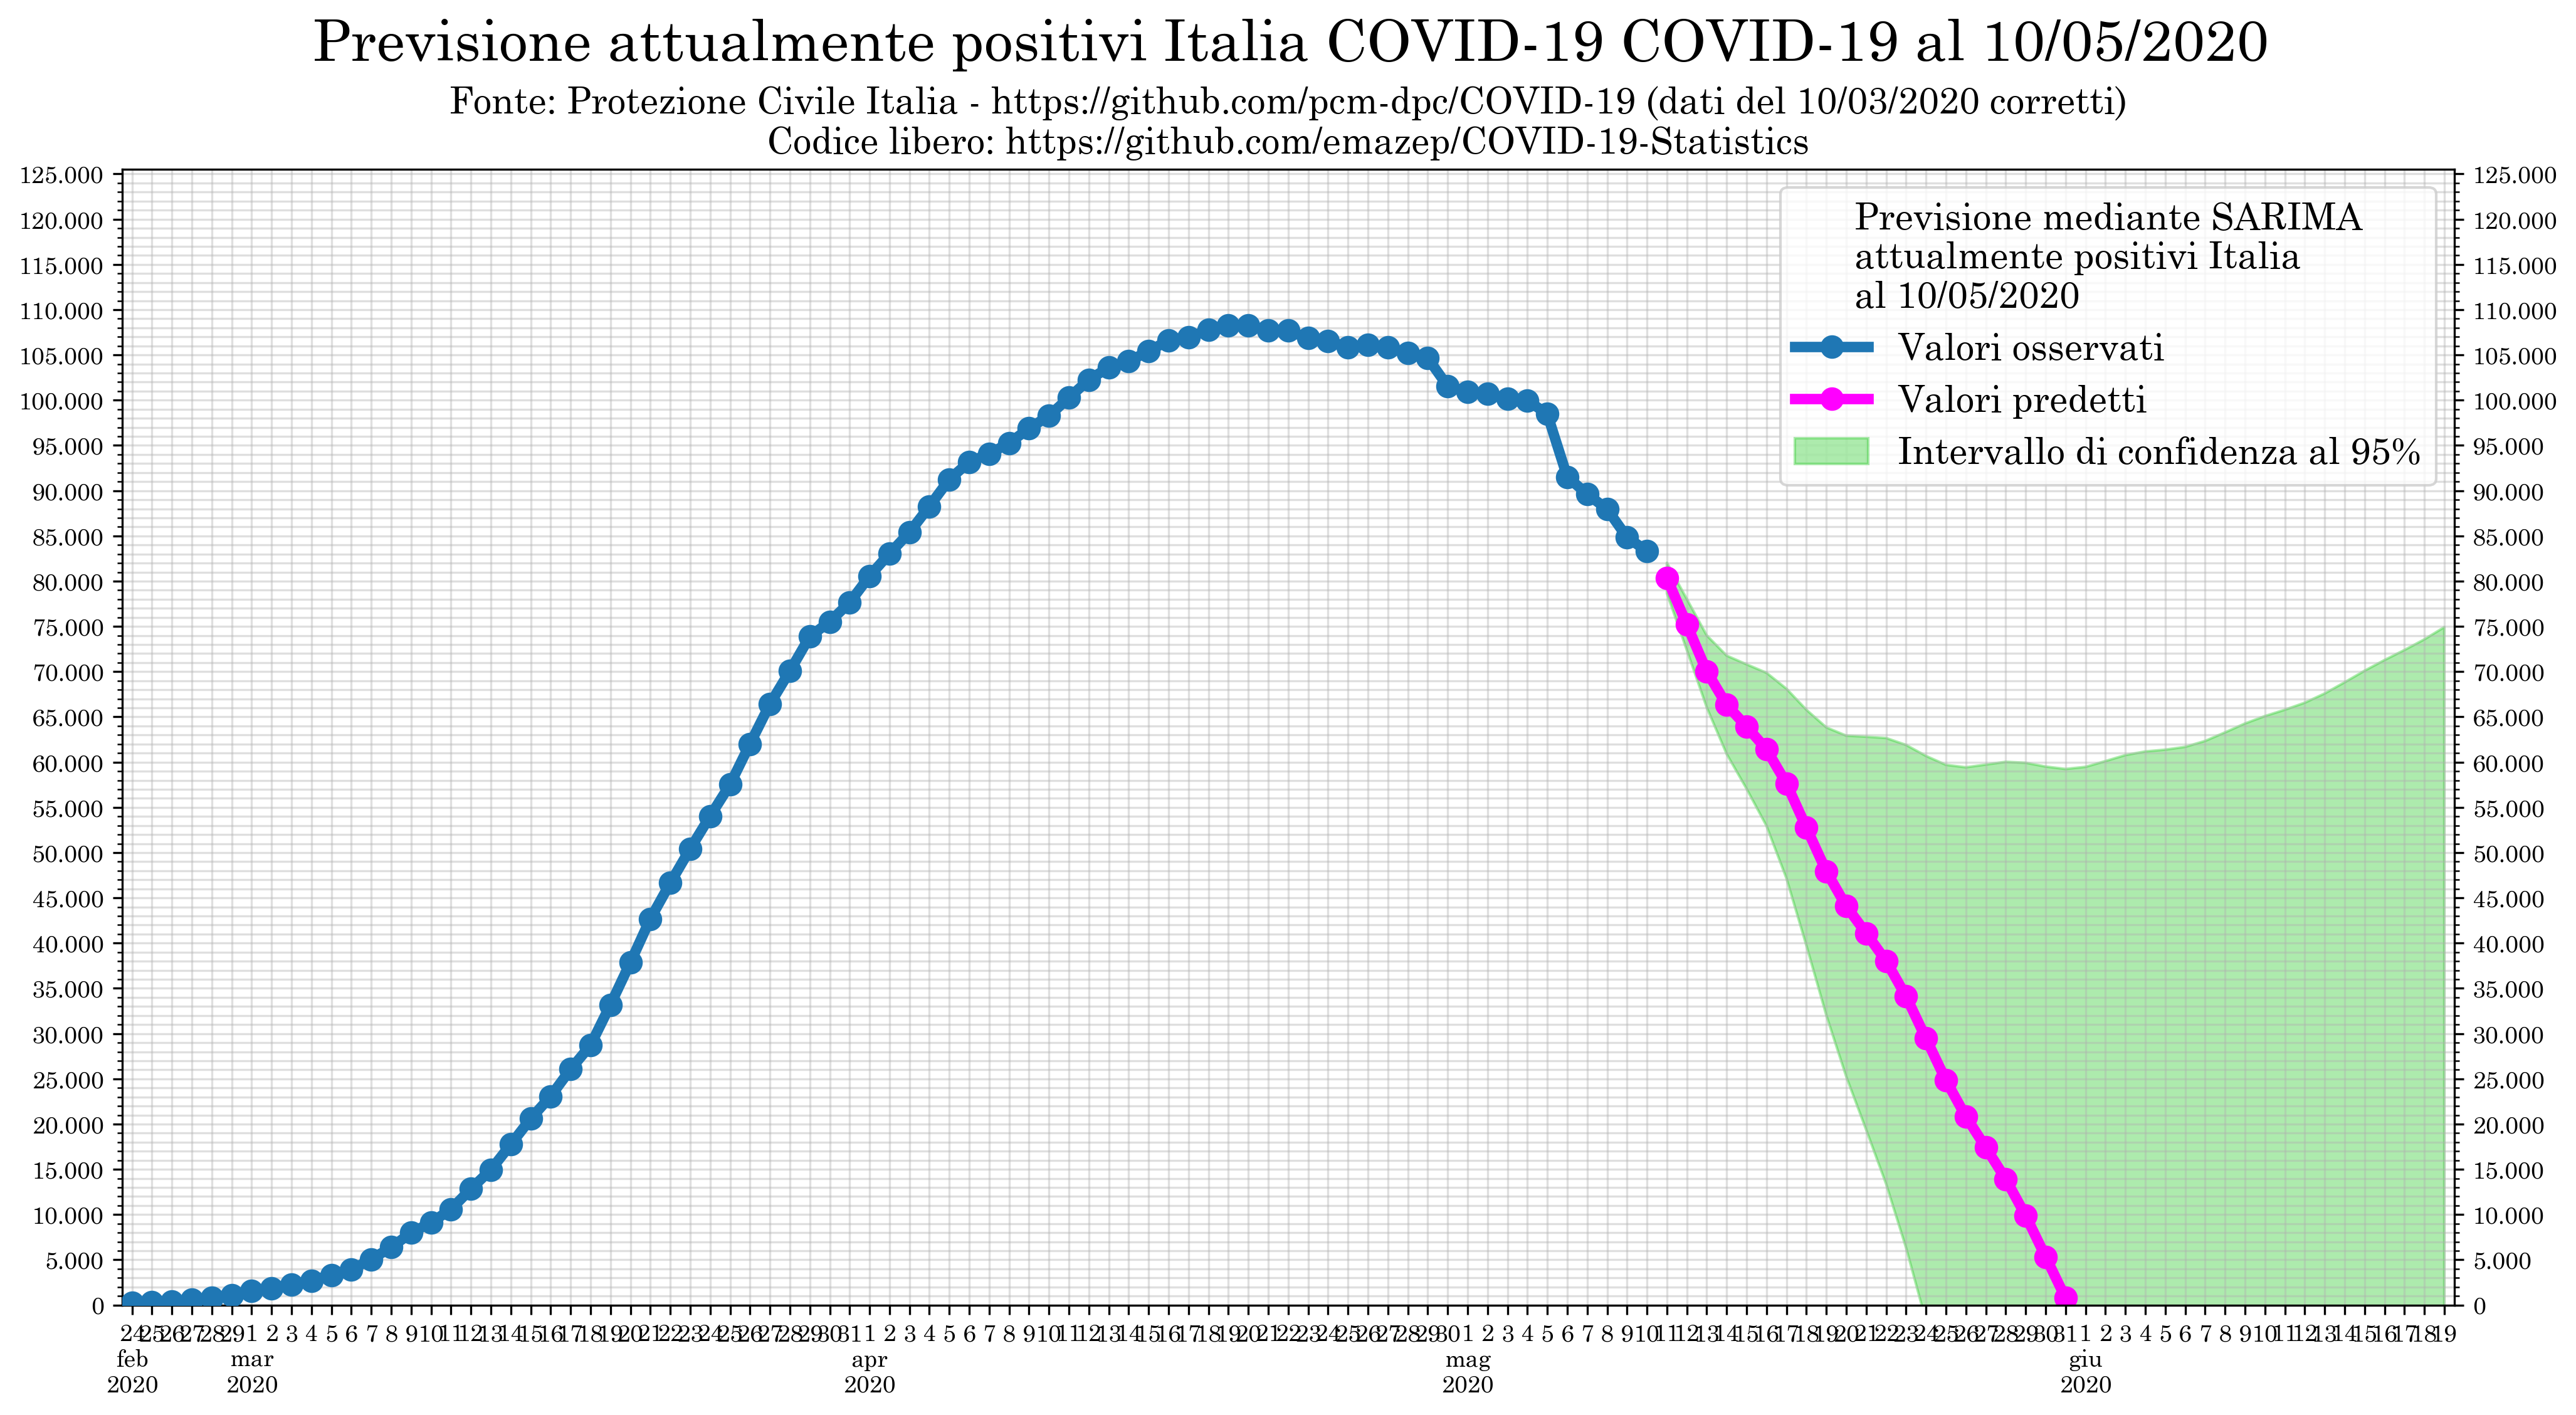

In [340]:
ds = ds_it
column = 'totale_positivi'
x_pred, predictions, conf_int = make_arima_pred(ds, column, periods=40, m=1)
fig_ARIMA_attualmente_positivi = plot_predictions(
    ds, column, x_pred, predictions, conf_int, 'attualmente positivi Italia COVID-19', 'attualmente positivi Italia', y_major=5000, y_minor=1000
)

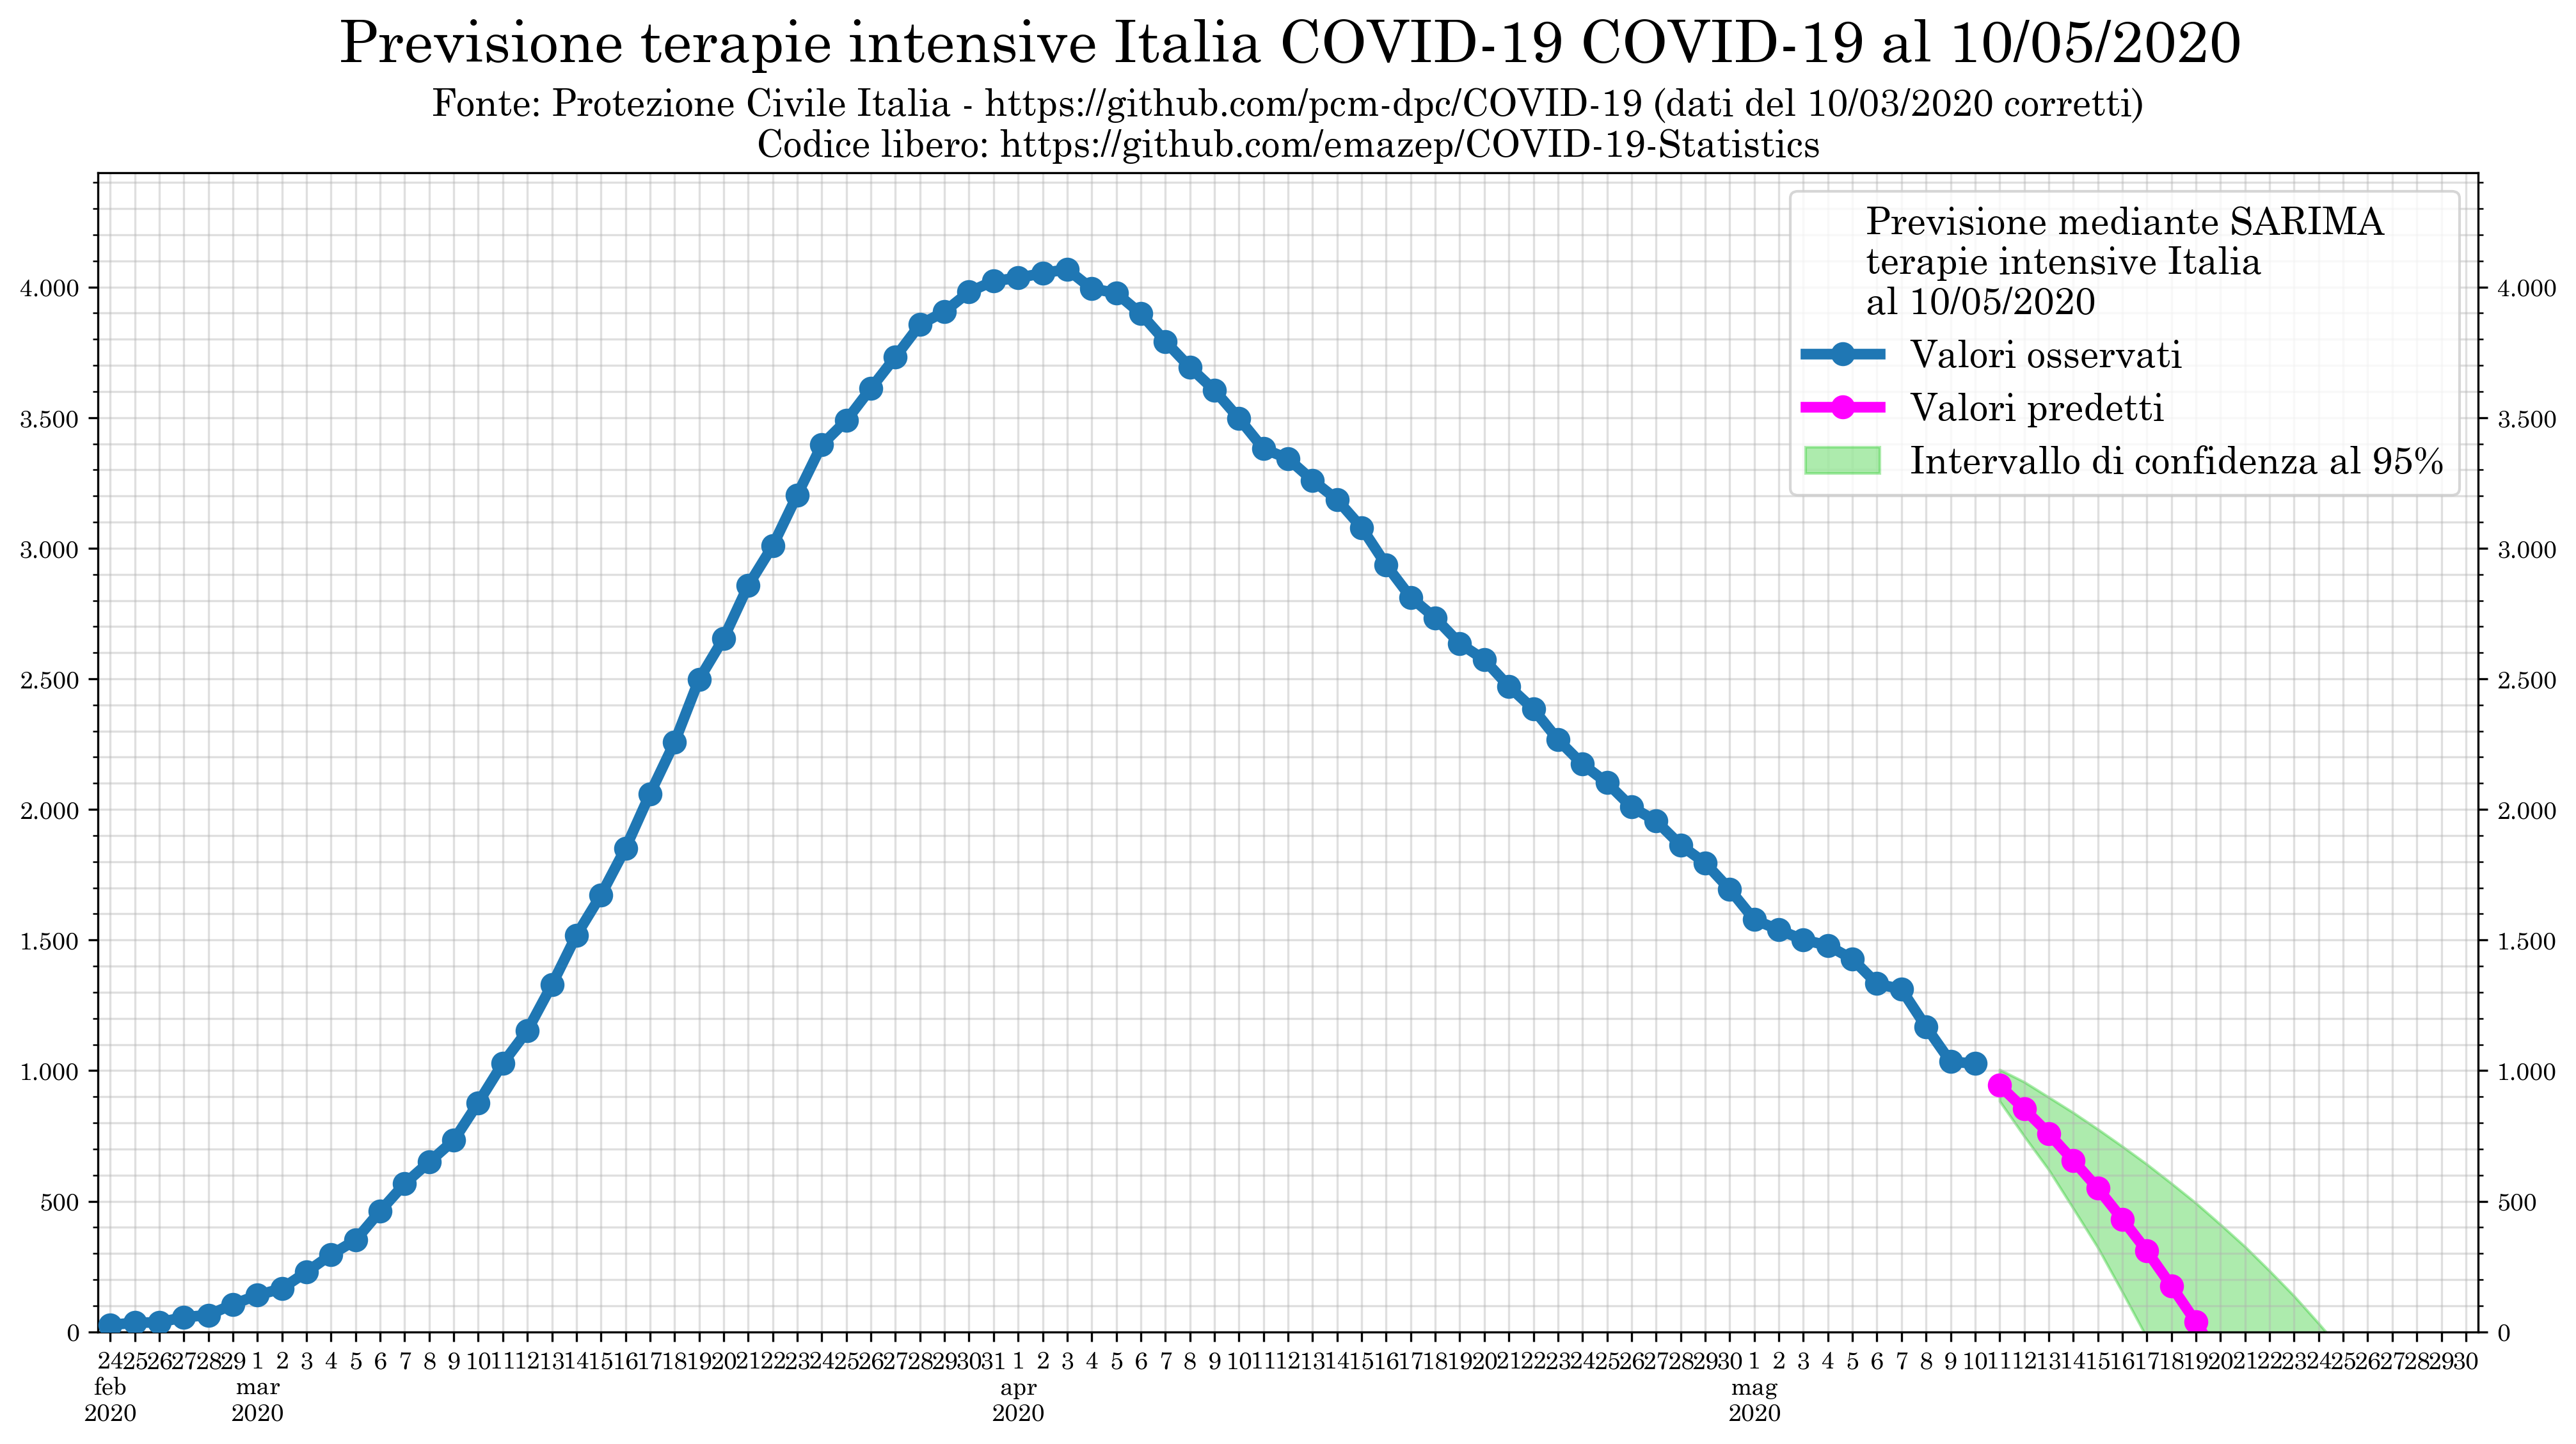

In [341]:
FROM = date.fromisoformat('2020-04-03')
#ds = ds_it[FROM:]
ds = ds_it
column = 'terapia_intensiva'
x_pred, predictions, conf_int = make_arima_pred(ds, column, periods=20, m=1)
fig_ARIMA_ICU = plot_predictions(
    ds, column, x_pred, predictions, conf_int, 'terapie intensive Italia COVID-19', 'terapie intensive Italia', y_major=500, y_minor=100
)

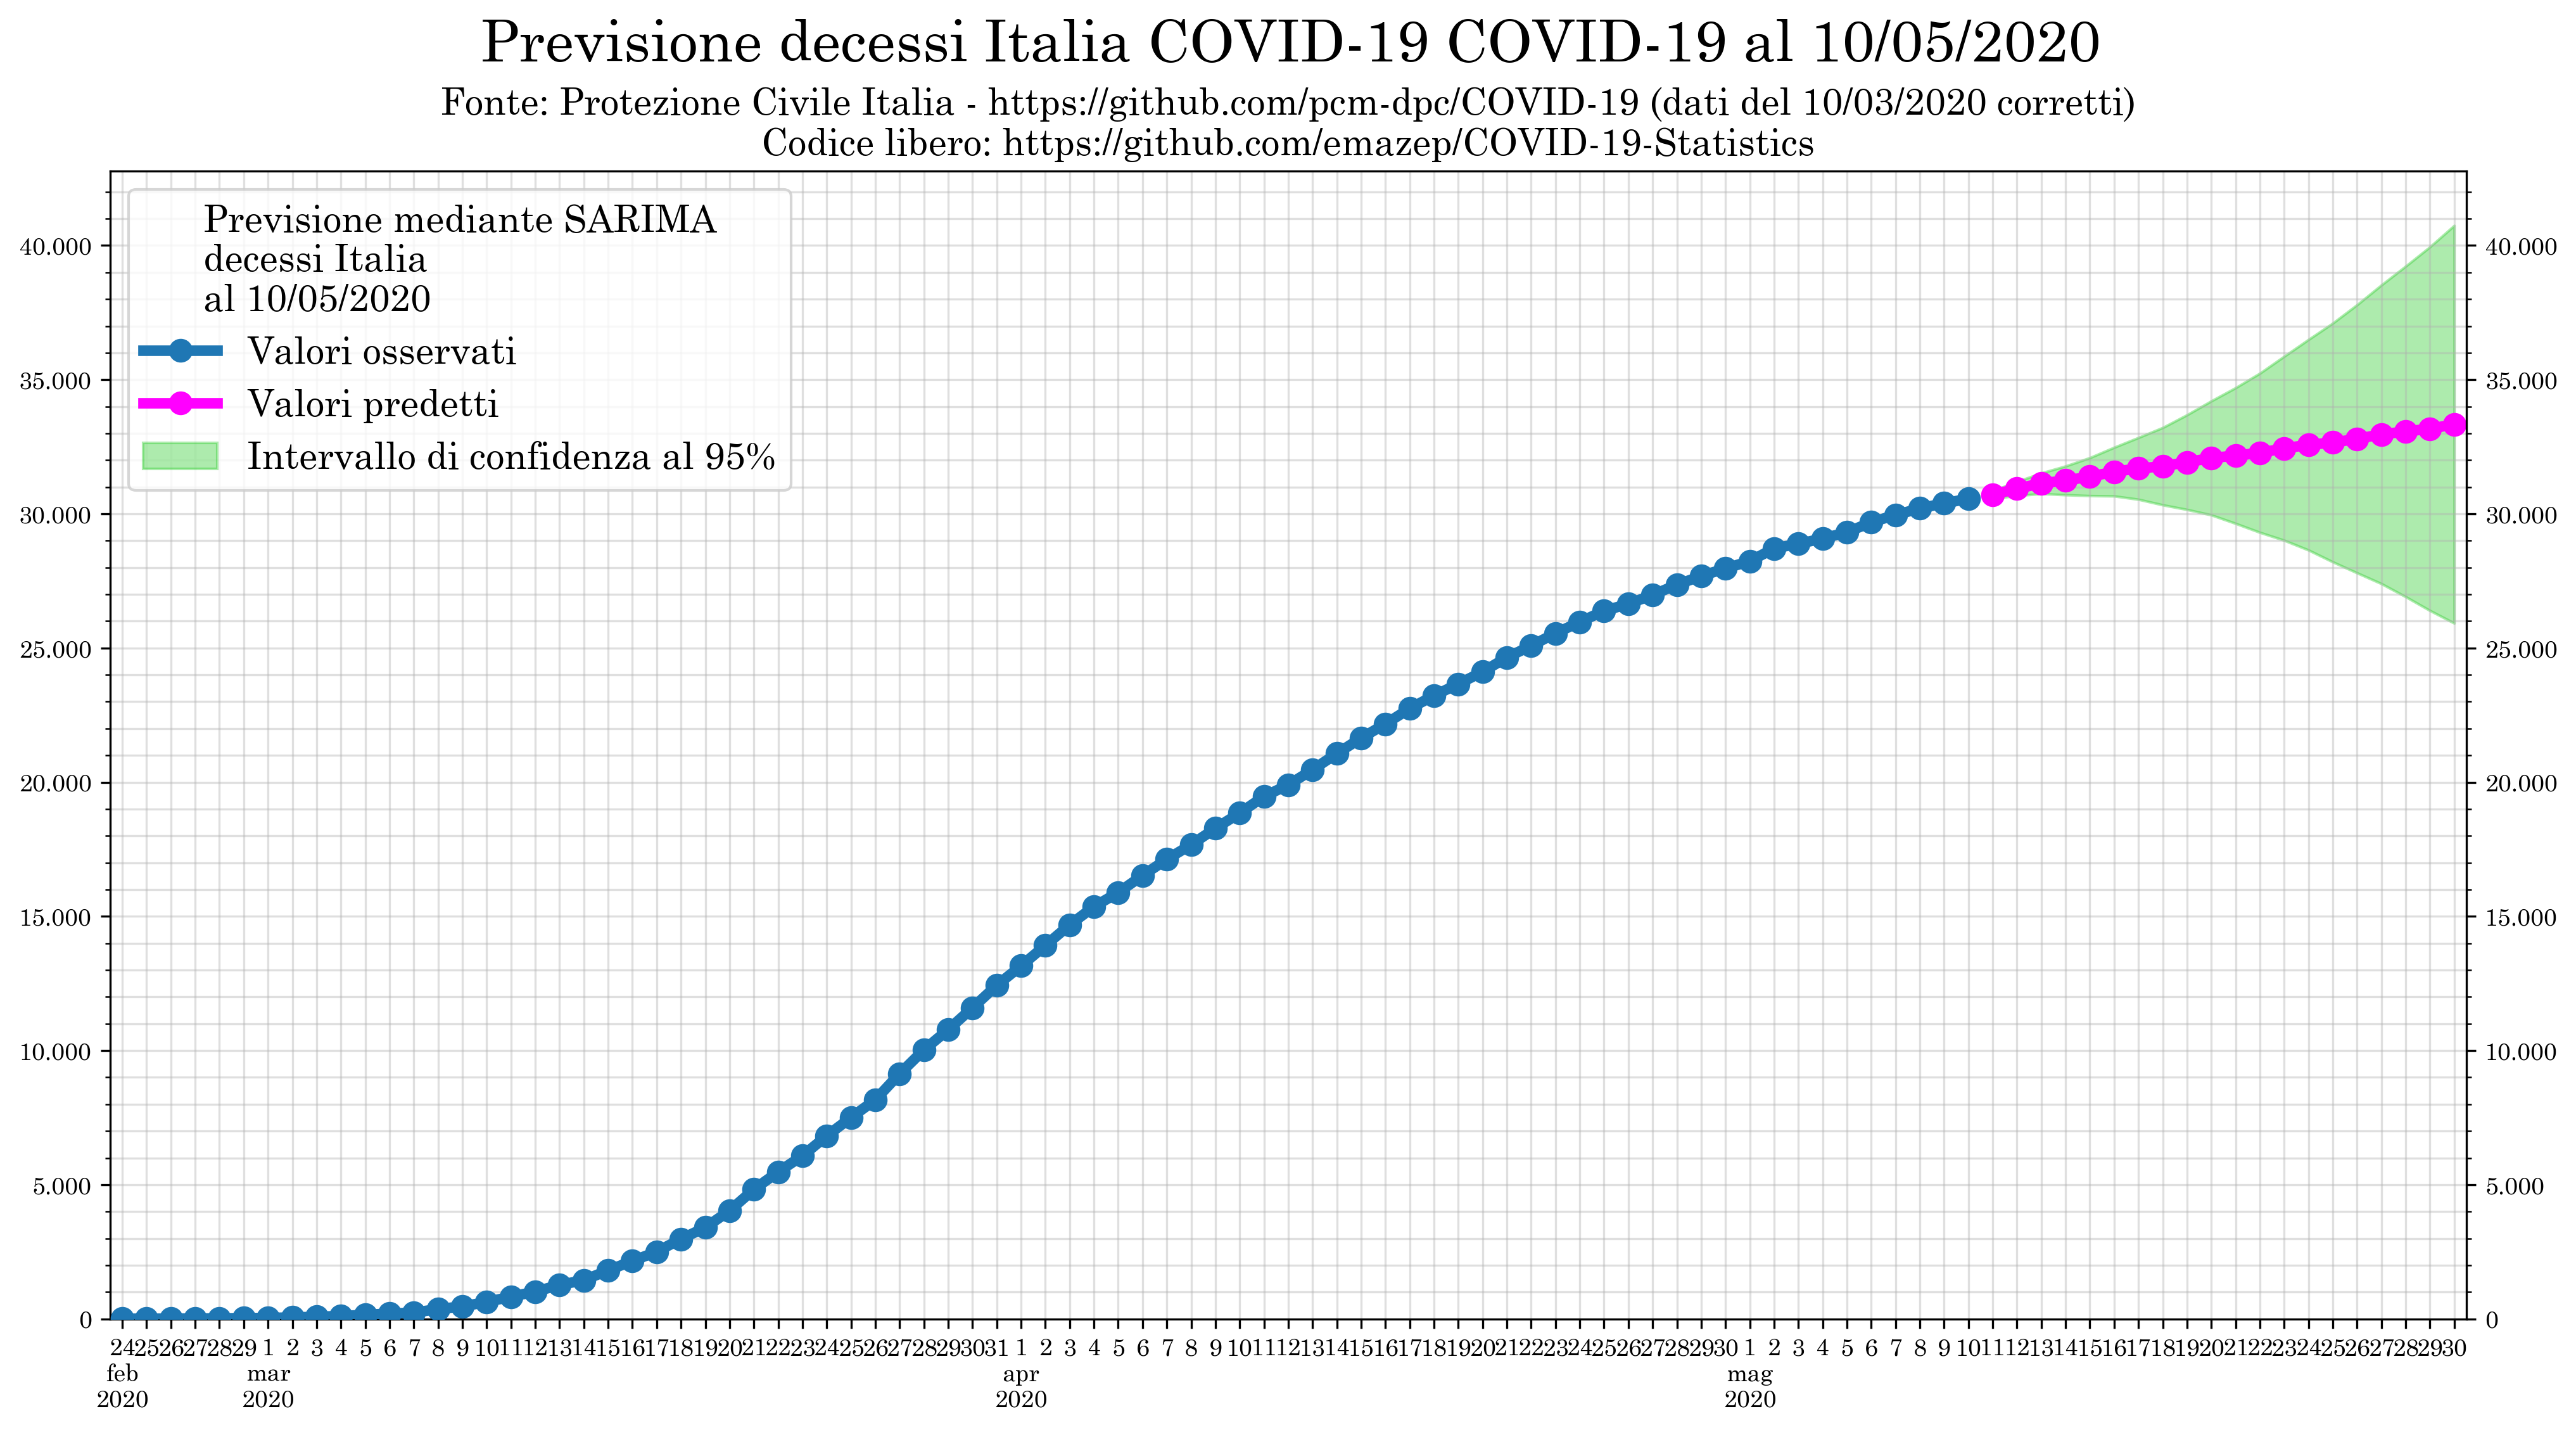

In [342]:
ds = ds_it
column = 'deceduti'
x_pred, predictions, conf_int = make_arima_pred(ds, column, periods=20, m=1)
fig_ARIMA_deaths = plot_predictions(
    ds, column, x_pred, predictions, conf_int, 'decessi Italia COVID-19', 'decessi Italia', y_major=5000, y_minor=1000
)

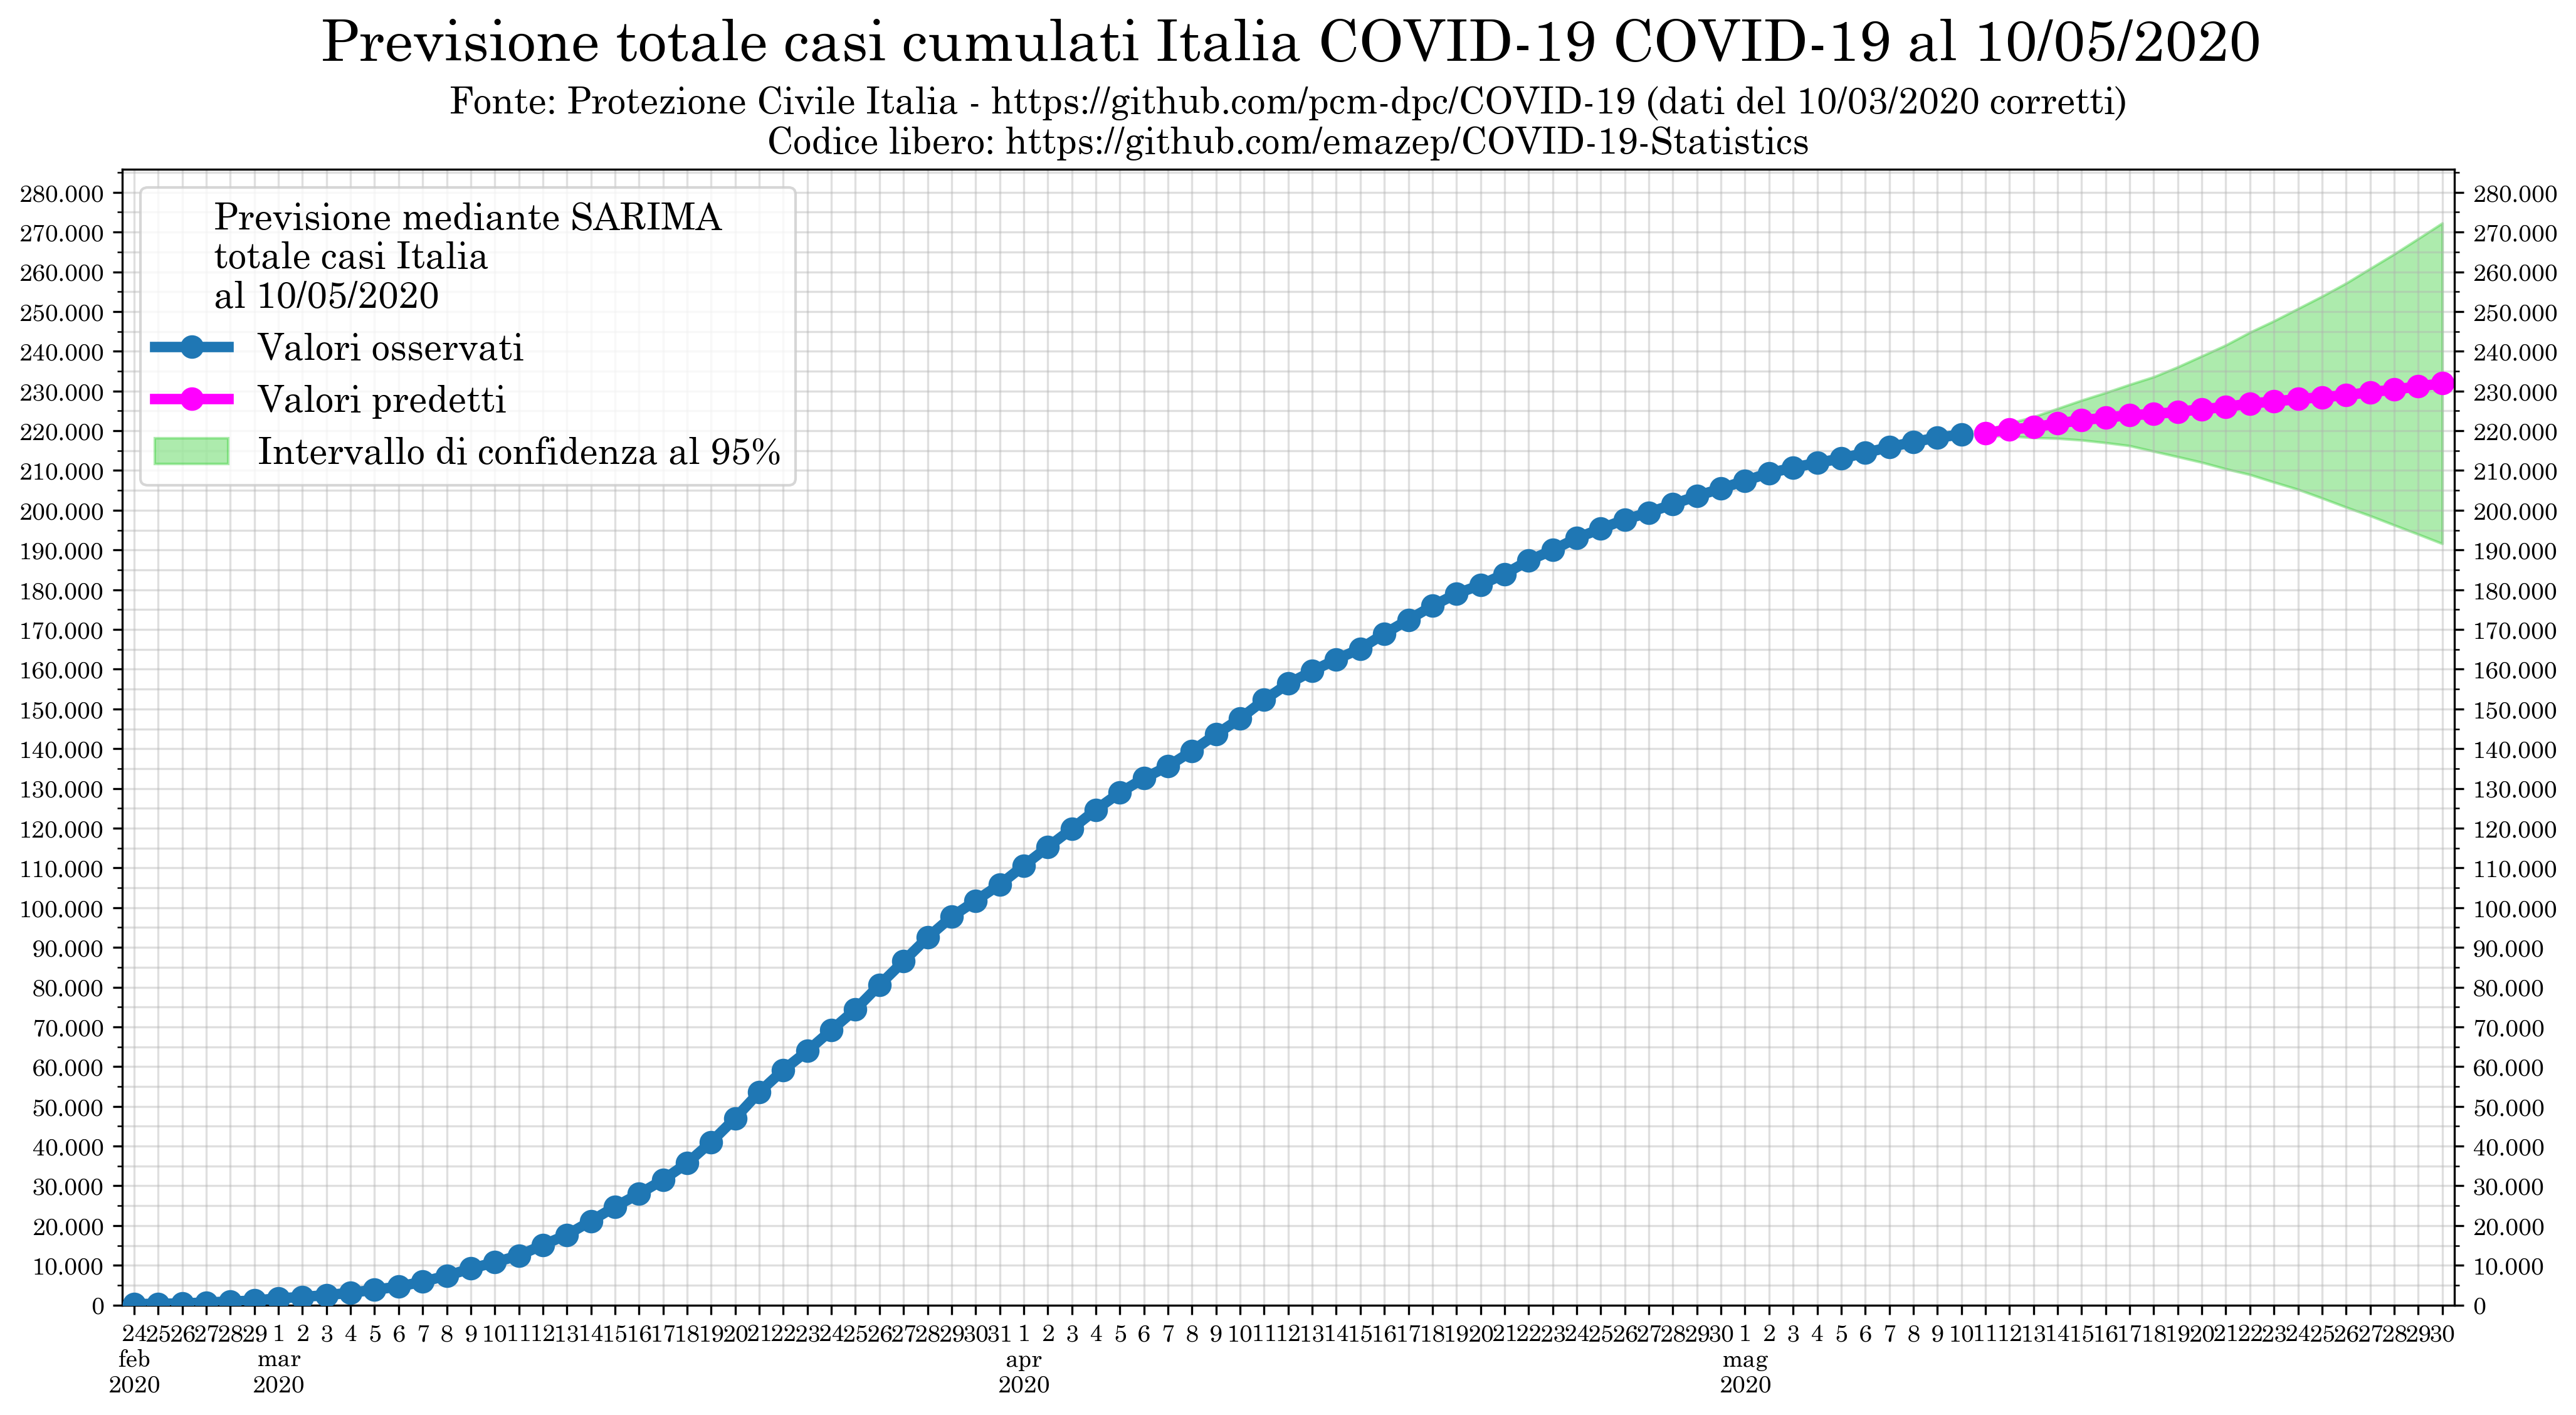

In [343]:
ds = ds_it
column = 'totale_casi'
x_pred, predictions, conf_int = make_arima_pred(ds, column, periods=20, m=7)
fig_ARIMA_totale_casi = plot_predictions(
    ds, column, x_pred, predictions, conf_int, 'totale casi cumulati Italia COVID-19', 'totale casi Italia', y_major=10000, y_minor=5000
)

In [326]:
with save_in_dir(OUTPUT_PATH):
    fig_ARIMA_totale_casi_DELTA.savefig('ARIMA_01_totale_casi_DELTA', transparent=False)